In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Using TensorFlow backend.


Number of Descriptor:68


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

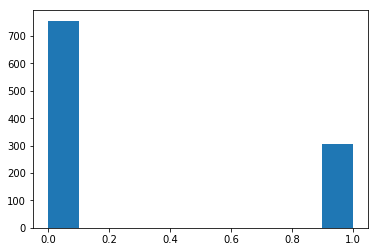

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])
feat_float = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='float')
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]
print('Number of Descriptor:' + str(len(selected_float_feat.loc[0])))
      
df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

In [3]:
from sklearn.preprocessing import normalize
norm_feat_float = normalize(selected_float_feat.values, axis=0, norm='max')

### plot with raw descriptors

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1063 samples in 0.002s...
[t-SNE] Computed neighbors for 1063 samples in 0.137s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1063
[t-SNE] Computed conditional probabilities for sample 1063 / 1063
[t-SNE] Mean sigma: 0.297367
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.778553
[t-SNE] KL divergence after 500 iterations: 0.885469


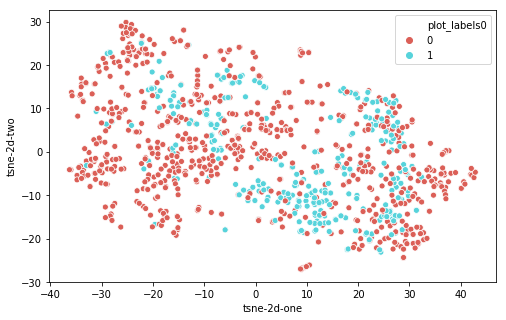

In [4]:
utilities.tsne_2d_visulization(input_feat=norm_feat_float, 
                               plot_labels=true_label_biclass)

### Options
* verbose = 0 to silence the t-SNE printing
* ax = ax_you_defined_outside to plot multiple figures

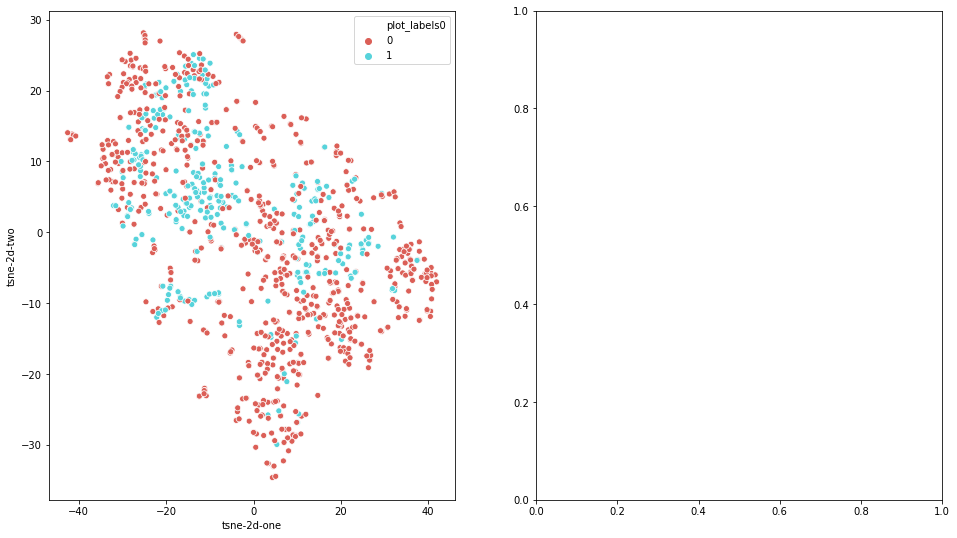

In [5]:
fig, ax=plt.subplots(1,2, figsize=(16,9))
utilities.tsne_2d_visulization(input_feat=norm_feat_float, 
                               plot_labels=true_label_biclass,
                               verbose=0,
                               ax=ax[0])

### Example of plotting with hidden layer from autoencoder or dce model

In [6]:
autoencoder_dims = [68,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()
loss = dce.train_model(selected_float_feat.values,clustering_loss='kld',
                       verbose=0, decoder_loss='mse', clustering_loss_weight=0.5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0.0 < 0.0001
Reached tolerance threshold. Stopping training.


In [7]:
from keras import Model
encoder = Model(inputs=dce.model.input, 
                outputs=dce.model.get_layer(name='embedding_layer').output)

hidden_feat = encoder.predict(selected_float_feat.values)
q , _ = dce.model.predict(selected_float_feat.values)
y_pred = q.argmax(1)

Text(0.5, 1.0, 'Using predicted Label')

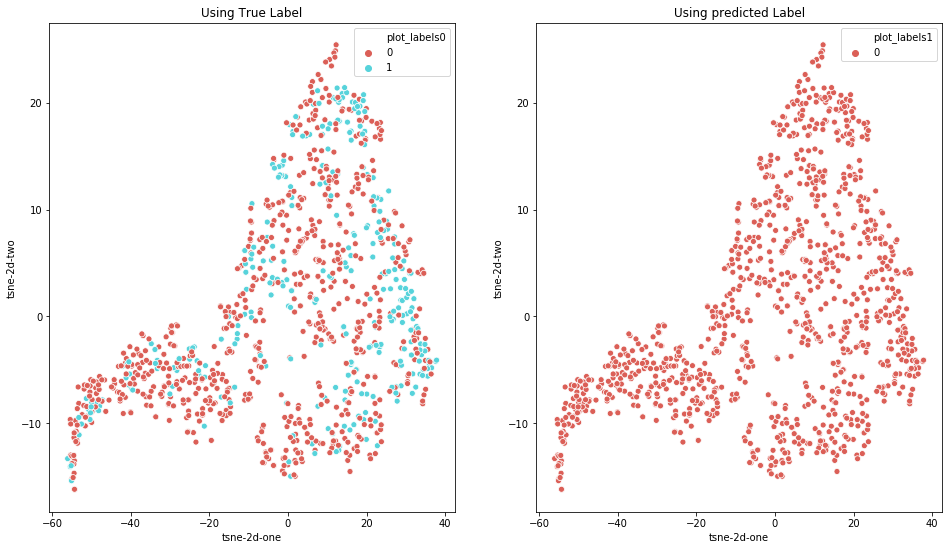

In [8]:
fig, ax=plt.subplots(1,2, figsize=(16,9))
utilities.tsne_2d_visulization(input_feat=hidden_feat, 
                               plot_labels=[true_label_biclass, y_pred],
                               verbose=0,ax=ax)
ax[0].set_title('Using True Label')
ax[1].set_title('Using predicted Label')

### Example of plotting with both testing and traing
labels could be list, or dict

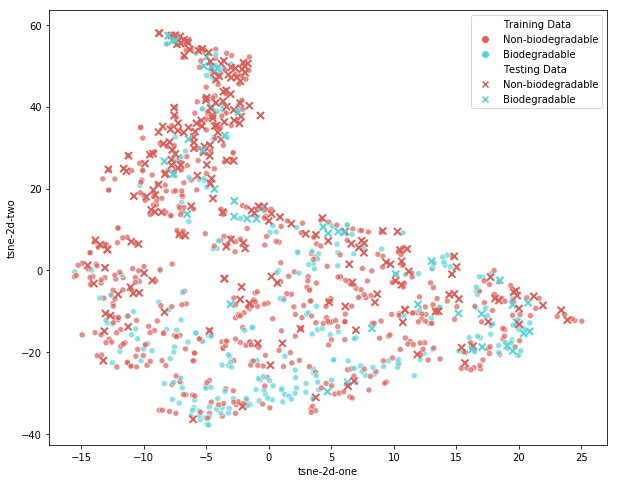

In [9]:
n_splitting = 800
utilities.tsne_2d_visulization_test_and_train(
    train_feat=hidden_feat[:n_splitting], 
    train_labels=true_label_biclass[:n_splitting],
    test_feat=hidden_feat[n_splitting:],
    test_labels=true_label_biclass[n_splitting:],
    labels=['Non-biodegradable', 'Biodegradable'],
    verbose=0,
    )